In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
# from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
# IMPORT XGBOOST
from xgboost import XGBClassifier
import warnings
import pickle
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import scipy.sparse as sp

In [3]:
from sklearnex import patch_sklearn
from cuml.svm import SVC
import cupy

In [4]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
metrics={'times':{},'accuracies':{},'macro_f1s':{},'macro_f1s_train':{},'accuracies_train':{}}

In [6]:
def model_classifier(X_train,X_test,y_train,y_test,model,model_name):
    mod = model
    params = mod.get_params()
    print(params)
        
    print(mod)
    print(f"{model_name} training")
    start_time = time.time()
    mod.fit(X_train, y_train)
    end_time = time.time()
    y_pred = mod.predict(X_test)
    y_pred_train = mod.predict(X_train)
    
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    accuracy_train = accuracy_score(y_train, y_pred_train)
    macro_f1_train = f1_score(y_train, y_pred_train, average='macro')

    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    metrics['times'][model_name] = (end_time-start_time)
    metrics['accuracies'][model_name] = accuracy
    metrics['macro_f1s'][model_name] = macro_f1
    metrics['accuracies_train'][model_name] = accuracy_train
    metrics['macro_f1s_train'][model_name] = macro_f1_train
    
    print("Accuracy:", accuracy)
    print("Macro f1:",macro_f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    return mod

### Reading the dataset and performing the train test split ###

In [7]:
data = pd.read_csv('/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv')
print(data.shape)
data.columns

(354862, 40)


Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [8]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['State',
 'Sex',
 'GeneralHealth',
 'LastCheckupTime',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [9]:
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')

In [10]:
# Perform train test split
# y = data['GeneralHealth']
# X = data.drop('GeneralHealth', axis=1)
standard_scaler = StandardScaler()  
label_encoder = LabelEncoder()


for i in categorical_features:
    data[i] = label_encoder.fit_transform(data[i])

X_train,X_test = train_test_split(data,test_size=0.2, random_state=42)
X_train.shape, X_test.shape


X_train[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

Y_test = X_test.pop('GeneralHealth')
Y_train = X_train.pop('GeneralHealth')

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


((283889, 39), (70973, 39), (283889,), (70973,))

## PCA

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


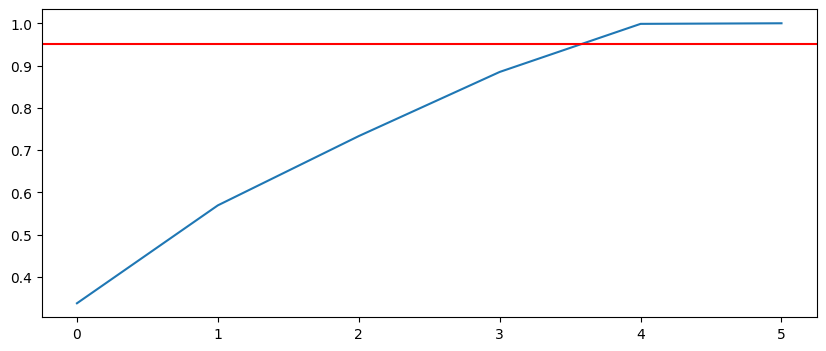

In [11]:
categorical_columns=categorical_features.copy()
categorical_columns.pop(categorical_columns.index('GeneralHealth'))


pca = PCA()
x_pca_2 = pca.fit(X_train[numerical_columns])
values = pca.explained_variance_ratio_

plt.figure(figsize = (10, 4))
ax = plt.subplot(111)

cumulative = np.cumsum(values)
ax.plot(cumulative)
plt.axhline(y=0.95, color='r', linestyle='-')
#print intersection point oh the red line with the curve

pca=PCA(n_components=4)
x_pca = pca.fit_transform(X_train[numerical_columns])

In [12]:
x_pca=pca.transform(X_train[numerical_columns])
x_pca = pd.DataFrame(x_pca)
x_pca = pd.concat([x_pca,X_train[categorical_columns]],axis=1)
X_train=x_pca.to_numpy()

x_pca=pca.transform(X_test[numerical_columns])
x_pca = pd.DataFrame(x_pca)
x_pca = pd.concat([x_pca,X_test[categorical_columns]],axis=1)
X_test=x_pca.to_numpy()
X_train.shape, X_test.shape

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


((283889, 37), (70973, 37))

## JL

In [13]:
def create_matrix_feature(d,n):
    matrix = np.random.normal(loc=0, scale=1.0/np.sqrt(n), size=(d, n))
    return matrix
output_dim=20
matrix_1=create_matrix_feature(X_train.shape[1],20)

In [14]:
# X_train=X_train.dot(matrix_1)
# X_test=X_test.dot(matrix_1)

### Naive Bayes ###

**Default**

In [15]:
model_naive  = model_classifier(X_train,X_test,Y_train,Y_test,GaussianNB(),"Naive_Bayes")
pickle.dump(model_naive, open('naive_bayes_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'priors': None, 'var_smoothing': 1e-09}
GaussianNB()
Naive_Bayes training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.3139503754949065
Macro f1: 0.32864062531532906
Confusion Matrix:
 [[ 9187   357   874    58   915]
 [ 1437  2974  2100  2051  1010]
 [ 9549  3541  4800   962  3703]
 [  122   781   273  1889   103]
 [15912  1586  3108   249  3432]]
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.81      0.39     11391
           1       0.32      0.31      0.32      9572
           2       0.43      0.21      0.28     22555
           3       0.36      0.60      0.45      3168
           4       0.37      0.14      0.21     24287

    accuracy                           0.31     70973
   macro avg       0.35      0.41      0.33     70973
weighted avg       0.37      0.31      0.29     70973



### Logistic Regression ###

**Default**

In [16]:
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,LogisticRegression(verbose=True),"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': True, 'warm_start': False}
LogisticRegression(verbose=True)
Logistic_Regression training


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          190     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56902D+05    |proj g|=  1.22481D+06

At iterate   50    f=  3.43892D+05    |proj g|=  3.80224D+04


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



At iterate  100    f=  3.38093D+05    |proj g|=  2.27641D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  190    100    115      1     0     0   2.276D+04   3.381D+05
  F =   338093.24202375696     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Accuracy: 0.4495512377946543
Macro f1: 0.38483556108485273
Confusion Matrix:
 [[ 1720    85  1583    32  7971]
 [  126  2856  4552   715  1323]
 [ 1008  1566 10116   253  9612]
 [    3  1604   534   925   102]
 [ 1631   395  5902    70 16289]]
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.15     

In [17]:
lr_model = LogisticRegression(random_state=42)

lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1],           
    'solver': ['liblinear', 'saga'] 
}

lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=-1)
print("-" * 20, "METRICS ON DATASET (Logistic Regression)", "-" * 20)
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,lr_grid,"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Logistic Regression) --------------------
{'cv': 3, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 42, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(random_state=42), 'n_jobs': -1, 'param_grid': {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1], 'solver': ['liblinear', 'saga']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1], 'penalty': ['l2'],
                         'solver': [

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.457357023093289
Macro f1: 0.38744107653336685
Confusion Matrix:
 [[ 1005    98  1634    12  8642]
 [   49  2887  4785   567  1284]
 [  450  1505 10507   138  9955]
 [    3  1471   577  1030    87]
 [  854   373  5991    38 17031]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.09      0.15     11391
           1       0.46      0.30      0.36      9572
           2       0.45      0.47      0.46     22555
           3       0.58      0.33      0.42      3168
           4       0.46      0.70      0.56     24287

    accuracy                           0.46     70973
   macro avg       0.47      0.38      0.39     70973
weighted avg       0.46      0.46      0.43     70973



### Random Forest ###

**Default**

In [18]:
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,RandomForestClassifier(verbose=True,n_jobs=-1),"Random_Forest")
pickle.dump(model_rf, open('model_rf_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': True, 'warm_start': False}
RandomForestClassifier(n_jobs=-1, verbose=True)
Random_Forest training


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_fi

Accuracy: 0.4506925168726135
Macro f1: 0.40443041516219214
Confusion Matrix:
 [[ 2249   128  2311     9  6694]
 [   65  3075  4769   601  1062]
 [  793  1858 11673   145  8086]
 [    6  1545   569   974    74]
 [ 2086   542  7600    43 14016]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.20      0.27     11391
           1       0.43      0.32      0.37      9572
           2       0.43      0.52      0.47     22555
           3       0.55      0.31      0.39      3168
           4       0.47      0.58      0.52     24287

    accuracy                           0.45     70973
   macro avg       0.46      0.38      0.40     70973
weighted avg       0.45      0.45      0.44     70973



In [19]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100],       
    'max_depth': [None, 10],         
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [1, 2]       
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (Random Forest)", "-" * 20)
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,rf_grid,"Random_Forest")
pickle.dump(model_rf, open('model_rf_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (Random Forest) --------------------
{'cv': 3, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [None, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
Grid

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated 

Accuracy: 0.4516365378383329
Macro f1: 0.40287148086847024
Confusion Matrix:
 [[ 1997   124  2248     9  7013]
 [   61  3121  4805   559  1026]
 [  737  1820 11651   146  8201]
 [    4  1566   555   975    68]
 [ 1874   473  7594    36 14310]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.18      0.25     11391
           1       0.44      0.33      0.37      9572
           2       0.43      0.52      0.47     22555
           3       0.57      0.31      0.40      3168
           4       0.47      0.59      0.52     24287

    accuracy                           0.45     70973
   macro avg       0.47      0.38      0.40     70973
weighted avg       0.45      0.45      0.44     70973



### Decision Tree ###

**Default**

In [20]:
model_dt = model_classifier(X_train,X_test,Y_train,Y_test,DecisionTreeClassifier(),"Decision_Tree")
pickle.dump(model_dt, open('model_dt_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
DecisionTreeClassifier()
Decision_Tree training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.35154213574176096
Macro f1: 0.3286278366063081
Confusion Matrix:
 [[3186  561 2908   62 4674]
 [ 624 2747 3291 1108 1802]
 [3027 3313 8221  666 7328]
 [  73 1135  730  963  267]
 [4968 1818 7420  248 9833]]
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.28      0.27     11391
           1       0.29      0.29      0.29      9572
           2       0.36      0.36      0.36     22555
           3       0.32      0.30      0.31      3168
           4       0.41      0.40      0.41     24287

    accuracy                           0.35     70973
   macro avg       0.33      0.33      0.33     70973
weighted avg       0.35      0.35      0.35     70973



In [21]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],     
    'max_depth': [5, 10],              
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2]            
}

dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-"*20,"METRICS ON DATASET", "-"*20)
model_dt_grid = model_classifier(X_train,X_test,Y_train,Y_test,dt_grid,"Decision_Tree")
pickle.dump(model_dt_grid, open('model_dt_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET --------------------
{'cv': 3, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 2}
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'min_sampl

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy: 0.44005466867682075
Macro f1: 0.37396922845211866
Confusion Matrix:
 [[ 1233   134  2059    19  7946]
 [   44  2986  4552   623  1367]
 [  468  1947 10699   177  9264]
 [    4  1557   601   895   111]
 [ 1237   592  6999    40 15419]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.11      0.17     11391
           1       0.41      0.31      0.36      9572
           2       0.43      0.47      0.45     22555
           3       0.51      0.28      0.36      3168
           4       0.45      0.63      0.53     24287

    accuracy                           0.44     70973
   macro avg       0.44      0.36      0.37     70973
weighted avg       0.44      0.44      0.42     70973



### SVM ###

**Default**

In [22]:
model_svm = model_classifier(X_train,X_test,Y_train,Y_test,SVC(verbose=True),"SVM")
pickle.dump(model_svm, open('model_svm_default.pkl', 'wb'))

{'handle': <pylibraft.common.handle.Handle object at 0x77fec97771b0>, 'verbose': 5, 'output_type': 'input', 'C': 1, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'coef0': 0.0, 'tol': 0.001, 'cache_size': 1024.0, 'max_iter': -1, 'nochange_steps': 1000, 'probability': False, 'random_state': None, 'class_weight': None, 'multiclass_strategy': 'ovo'}
SVC()
SVM training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


[D] [11:36:43.335927] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:36:46.658643] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 124 outer iterations, total inner 27913 iterations, and diff 0.000808
[D] [11:36:46.859415] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:36:58.643816] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 369 outer iterations, total inner 71466 iterations, and diff 0.000970
[D] [11:36:58.690837] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:36:59.268725] /opt/conda/conda-bld/work/cpp/src/svm/smosolver.cuh:205 SMO solver finished after 31 outer iterations, total inner 7078 iterations, and diff 0.000828
[D] [11:36:59.329031] /opt/conda/conda-bld/work/cpp/src/svm/workingset.h:100 Creating working set with 1024 elements
[D] [11:37:1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4476491059980556
Macro f1: 0.3075730606883237
Confusion Matrix:
 [[    0    73  1418     5  9895]
 [    0  2812  5113   101  1546]
 [    0  1196  9990    20 11349]
 [    0  2075   658   321   114]
 [    0   311  5322     6 18648]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     11391
           1       0.43      0.29      0.35      9572
           2       0.44      0.44      0.44     22555
           3       0.71      0.10      0.18      3168
           4       0.45      0.77      0.57     24287

    accuracy                           0.45     70973
   macro avg       0.41      0.32      0.31     70973
weighted avg       0.38      0.45      0.39     70973



### Ada Boost ###


**Default**

In [23]:
model_ada = model_classifier(X_train,X_test,Y_train,Y_test,AdaBoostClassifier(),"ADA_Boost")
pickle.dump(model_ada, open('model_ada_default.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
AdaBoostClassifier()
ADA_Boost training


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._

Accuracy: 0.4541727135671312
Macro f1: 0.3745681129602783
Confusion Matrix:
 [[  378   124  1746    16  9127]
 [   46  3088  4419   712  1307]
 [  326  1784 10514   199  9732]
 [    8  1445   500  1122    93]
 [  374   480  6239    62 17132]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.03      0.06     11391
           1       0.45      0.32      0.37      9572
           2       0.45      0.47      0.46     22555
           3       0.53      0.35      0.43      3168
           4       0.46      0.71      0.56     24287

    accuracy                           0.45     70973
   macro avg       0.44      0.38      0.37     70973
weighted avg       0.44      0.45      0.41     70973



In [24]:
ab_model = AdaBoostClassifier(random_state=42)

ab_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1, 1] 
}

ab_grid = GridSearchCV(ab_model, ab_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (AdaBoost)", "-" * 20)
model_ada_grid = model_classifier(X_train,X_test,Y_train,Y_test,ab_grid,"ADA_Boost")
pickle.dump(model_ada_grid, open('model_ada_grid.pkl', 'wb'))

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (AdaBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__algorithm': 'SAMME.R', 'estimator__base_estimator': 'deprecated', 'estimator__estimator': None, 'estimator__learning_rate': 1.0, 'estimator__n_estimators': 50, 'estimator__random_state': 42, 'estimator': AdaBoostClassifier(random_state=42), 'n_jobs': 4, 'param_grid': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'f1_macro', 'verbose': 4}
GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100]},
             scoring='f1_macro', verbose=4)
ADA_Boost training
Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._a

Accuracy: 0.4564693615882096
Macro f1: 0.385864338783599
Confusion Matrix:
 [[  772   115  1744    22  8738]
 [   88  3087  4473   695  1229]
 [  595  1780 10713   187  9280]
 [   11  1452   504  1110    91]
 [  729   445  6343    55 16715]]
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.07      0.11     11391
           1       0.45      0.32      0.38      9572
           2       0.45      0.47      0.46     22555
           3       0.54      0.35      0.42      3168
           4       0.46      0.69      0.55     24287

    accuracy                           0.46     70973
   macro avg       0.45      0.38      0.39     70973
weighted avg       0.44      0.46      0.42     70973



### XG Boost ###

**Default**

In [25]:
model_xg = model_classifier(cupy.array(X_train),cupy.array(X_test),Y_train,Y_test,XGBClassifier(device='cuda'),"XG_Boost")
pickle.dump(model_xg, open('model_xg_default.pkl', 'wb'))

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None,

In [26]:
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],      
    'subsample': [0.8, 1.0]    
}

# Setup GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)

# Train and save the model
print("-" * 20, "METRICS ON DATASET (XGBoost)", "-" * 20)
model_xgb_grid = model_classifier(cupy.array(X_train), cupy.array(X_test), Y_train, Y_test, xgb_grid, "XG_Boost")
pickle.dump(model_xgb_grid, open('model_xgb_grid.pkl', 'wb'))


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


-------------------- METRICS ON DATASET (XGBoost) --------------------
{'cv': 3, 'error_score': nan, 'estimator__objective': 'binary:logistic', 'estimator__base_score': None, 'estimator__booster': None, 'estimator__callbacks': None, 'estimator__colsample_bylevel': None, 'estimator__colsample_bynode': None, 'estimator__colsample_bytree': None, 'estimator__device': None, 'estimator__early_stopping_rounds': None, 'estimator__enable_categorical': False, 'estimator__eval_metric': None, 'estimator__feature_types': None, 'estimator__gamma': None, 'estimator__grow_policy': None, 'estimator__importance_type': None, 'estimator__interaction_constraints': None, 'estimator__learning_rate': None, 'estimator__max_bin': None, 'estimator__max_cat_threshold': None, 'estimator__max_cat_to_onehot': None, 'estimator__max_delta_step': None, 'estimator__max_depth': None, 'estimator__max_leaves': None, 'estimator__min_child_weight': None, 'estimator__missing': nan, 'estimator__monotone_constraints': None, 'es

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:46:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:46:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

[CV 3/3] END learning_rate=0.01, n_estimators=50;, score=0.230 total time=  23.5s
[CV 1/3] END learning_rate=0.1, n_estimators=50;, score=0.256 total time=  23.1s
[CV 3/3] END learning_rate=0.1, n_estimators=50;, score=0.256 total time=  22.6s
[CV 1/3] END ..learning_rate=1, n_estimators=50;, score=0.369 total time=  23.2s
[CV 2/3] END ..learning_rate=1, n_estimators=50;, score=0.370 total time=  23.5s
[CV 3/3] END .learning_rate=1, n_estimators=100;, score=0.386 total time=  42.5s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0;, score=0.335 total time=  11.6s


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3] END learning_rate=0.01, n_estimators=50;, score=0.229 total time=  23.0s
[CV 2/3] END learning_rate=0.01, n_estimators=100;, score=0.230 total time=  45.2s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.293 total time=  45.5s
[CV 3/3] END ..learning_rate=1, n_estimators=50;, score=0.370 total time=  23.1s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8;, score=0.336 total time=  12.2s
[CV 2/3] END learning_rate=0.01, n_estimators=50;, score=0.229 total time=  23.6s
[CV 3/3] END learning_rate=0.01, n_estimators=100;, score=0.231 total time=  45.7s
[CV 3/3] END learning_rate=0.1, n_estimators=100;, score=0.298 total time=  46.3s
[CV 2/3] END .learning_rate=1, n_estimators=100;, score=0.376 total time=  39.9s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8;, score=0.338 total time=  11.8s
[CV 1/3] END learning_rate=0.01, n_estimators=100;, score=0.230 total time=  45.3s
[CV 2/3] END learning_rate=0.1, n_estimat

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:46:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:46:35] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cpu, while the input data is on: cuda:0.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Accuracy: 0.4644160455384442
Macro f1: 0.41166618997079707
Confusion Matrix:
 [[ 1581   116  1944    14  7736]
 [   47  3130  4676   676  1043]
 [  561  1829 11229   167  8769]
 [    2  1443   485  1169    69]
 [ 1271   456  6658    50 15852]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.14      0.21     11391
           1       0.45      0.33      0.38      9572
           2       0.45      0.50      0.47     22555
           3       0.56      0.37      0.45      3168
           4       0.47      0.65      0.55     24287

    accuracy                           0.46     70973
   macro avg       0.48      0.40      0.41     70973
weighted avg       0.46      0.46      0.44     70973



In [27]:
df = pd.DataFrame(metrics)
df.to_csv("Metrics.csv")
df

,times,accuracies,macro_f1s,macro_f1s_train,accuracies_train
Naive_Bayes,0.208781,0.313950,0.328641,0.324252,0.311791
Logistic_Regression,140.989292,0.457357,0.387441,0.390150,0.458651
Random_Forest,552.510053,0.451637,0.402871,0.995456,0.996157
Decision_Tree,31.206321,0.440055,0.373969,0.408578,0.460335
SVM,98.168821,0.447649,0.307573,0.309674,0.449637
ADA_Boost,194.582767,0.456469,0.385864,0.385600,0.455889
XG_Boost,272.502932,0.464416,0.411666,0.465401,0.500706


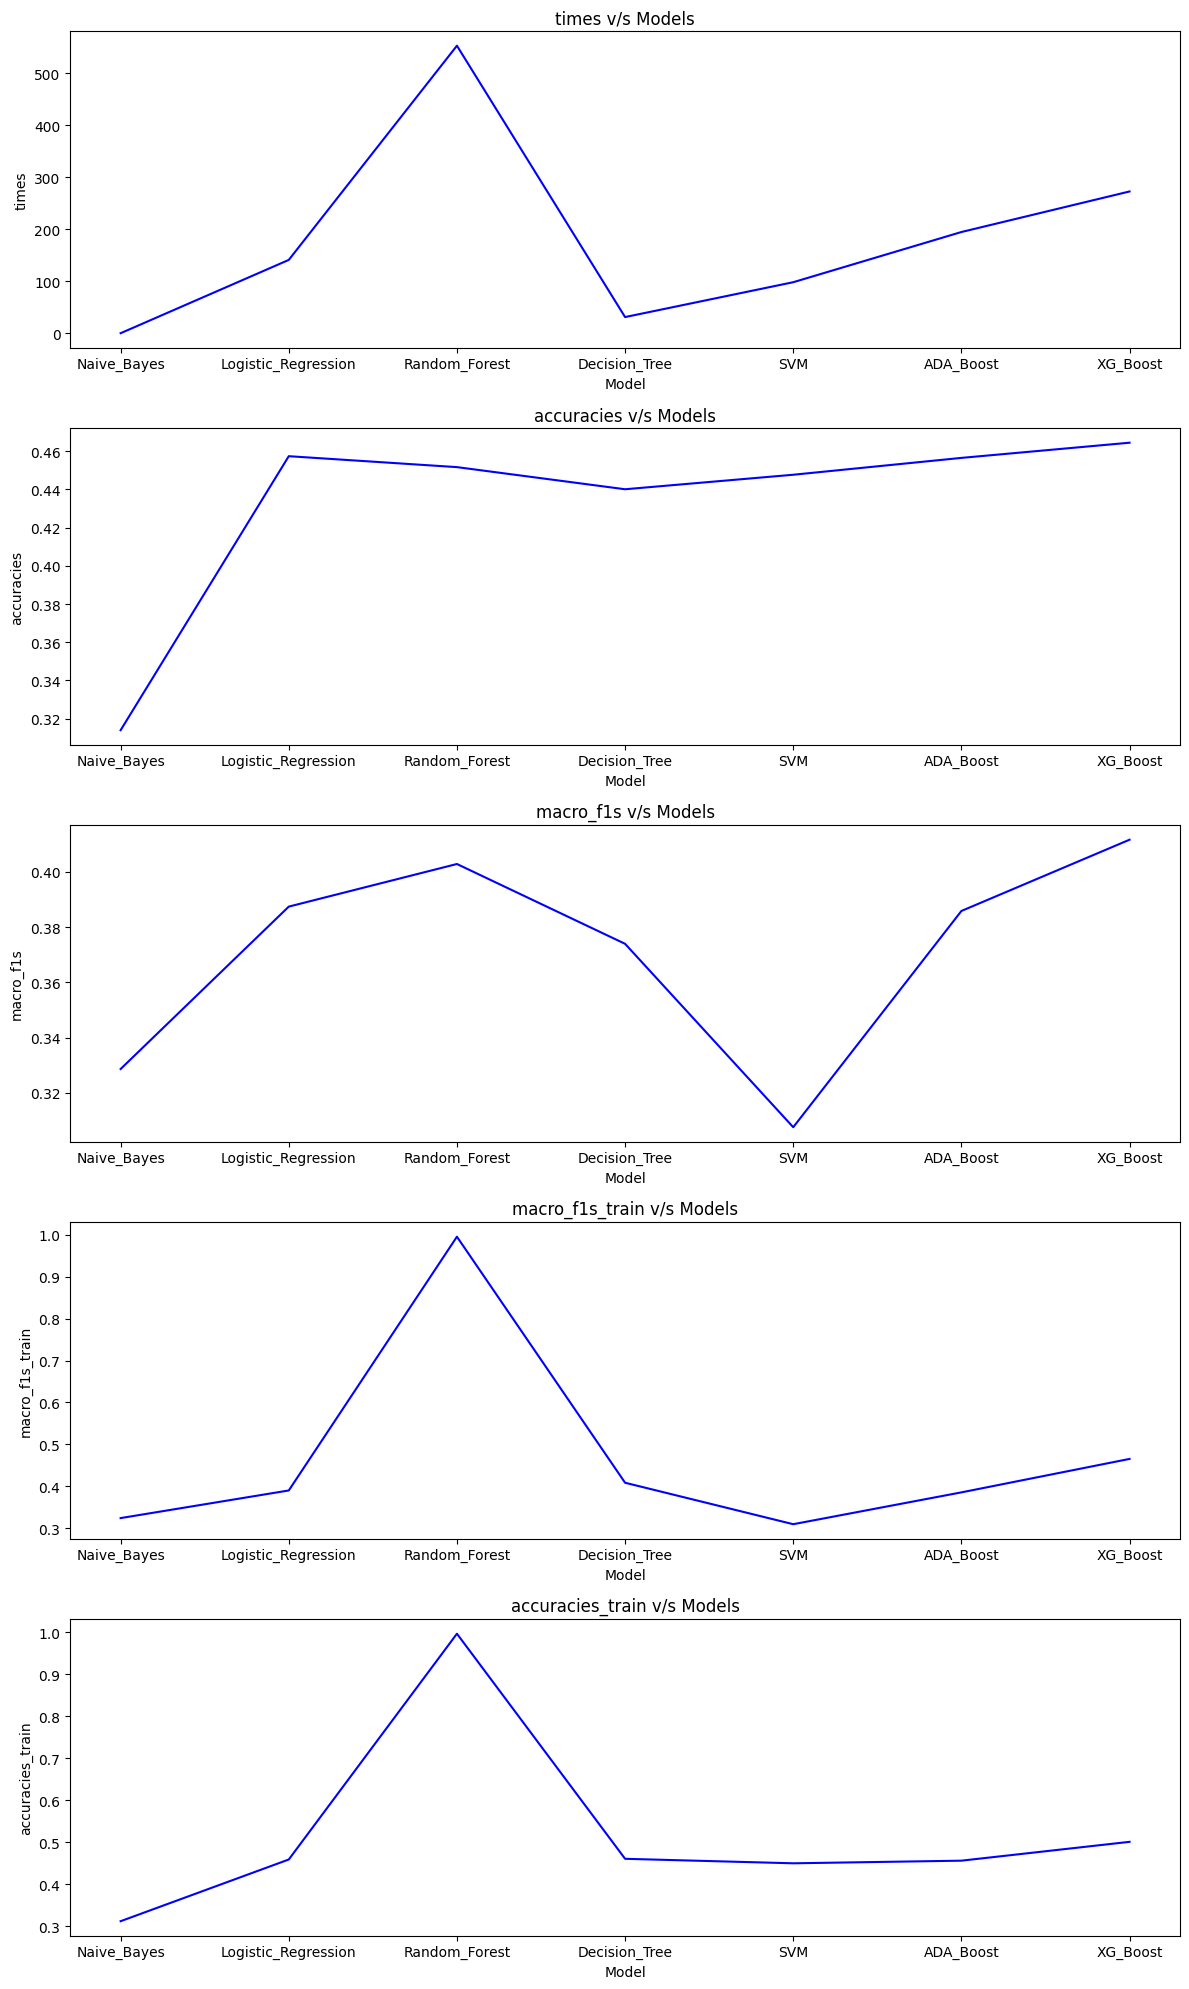

In [28]:
models = [df.index[i] for i in range(df.shape[0])]
metrics = [df.columns[i] for i in range(df.shape[1])]

fig,axes = plt.subplots(5,figsize=(12,20))

for i in range(len(metrics)):
    # print(i)
    # print(row)
    row = df.iloc[:,i]
    axes[i].set_title(f"{metrics[i]} v/s Models")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(f"{metrics[i]}")
    axes[i].plot(models,row,color='blue')
    
plt.tight_layout()
plt.savefig("Metrics.png")
plt.show()